In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
os.chdir('..')

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [20]:
import pandas as pd
from modules.representation_schemes import enc1d_features, get_PTR_features
from modules.function import get_metrics, pymatgen_comp, get_elem_count, data_generator_vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from modules.model_select import rmse, corr
from sklearn.model_selection import KFold, train_test_split
from sklearn import metrics
import json
import pickle
import torch
from uncertainties import ufloat
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [8]:
ys_df_loc = 'dataset/yield_strength.csv'
ys_df = pd.read_csv(ys_df_loc, index_col=0)
comps = ys_df['Composition'].values
process = ys_df['As-cast/other'].values.reshape(-1,1)
phase = ys_df['Single/MultiPhase'].values
single_phase = pd.get_dummies(phase).values[:,1].reshape(-1,1)
temp = ys_df['Temperature (Celcius)'].values.reshape(-1,1)
y = ys_df['Yield Strength'].values
samples_per_bin, bins, = np.histogram(ys_df['Yield Strength'], bins=np.arange(100,1000,100)) 
min_bin_size = samples_per_bin.min()
n_bins = len(samples_per_bin)
ys_df['bin_name'] = np.digitize(ys_df['Yield Strength'].values,bins)

pmg_comps = pymatgen_comp(comps)
additional = np.concatenate([process,single_phase,temp],axis=1)

In [9]:
with open('misc/pca_results_ys.pkl','rb') as fid: ##95% explained variance
    pca_dict = pickle.load(fid)
component_dict = pca_dict[0.95]

## Random Subsampling

In [16]:
filename = 'misc/hea_ys_random_subsampling_split.json'
create_new = True
if os.path.exists(filename) and not create_new:
    with open(filename,'rb') as fid:
        kfold_dict_random_subsampling = pickle.load(fid)
        print('Split file loaded')
else:
    np.random.seed(0)
    kfold_dict_random_subsampling = {}
    for i in np.geomspace(0.01,0.99,10):
        remove_inds_list = []
        retain_inds_list = []
        to_retain = int(len(comps)*i)
        for j in range(20):
            remaining_inds = np.random.choice(len(comps),to_retain, replace=False)
            remove_inds = list(set(np.arange(len(comps))) - set(remaining_inds))
            remove_inds_list.append(remove_inds)
            retain_inds_list.append(remaining_inds)
        kfold_dict_random_subsampling[np.round(i,2)] = {'remove':remove_inds_list,'retain':retain_inds_list}

    with open(filename,'wb') as fid:
        pickle.dump(kfold_dict_random_subsampling,fid)
    print('Split file written!')

Split file written!


In [17]:
np.random.seed(0)
dset = data_generator_vec(pymatgen_comp(comps))
methods = ['baseline','dense','atomic','random','random-tr','pettifor','mod_pettifor','PTR']
method_dict = {}
for method in methods:
    print(f'{method}')
    if method == 'baseline':
        features = dset.real_data
    else:
        if method == 'atomic':
            extracted = enc1d_features(pmg_comps,'atomic')
        elif method == 'random':
            extracted = enc1d_features(pmg_comps,'random')
        elif method == 'random-tr':
            extracted = enc1d_features(pmg_comps,'random-tr')
        elif method == 'pettifor':
            extracted = enc1d_features(pmg_comps,'pettifor')
        elif method == 'mod_pettifor':
            extracted = enc1d_features(pmg_comps,'mod_pettifor')
        elif method == 'PTR':
            extracted = get_PTR_features(pmg_comps)
        elif method =='dense':
            extracted = enc1d_features(pmg_comps,'dense')
        ind = component_dict[method]
        pca = PCA(n_components=ind, whiten=True)
        features = pca.fit_transform(extracted)
    features = np.concatenate((features,additional),axis=1)
    random_subsampling_dict = {}
    for k in kfold_dict_random_subsampling.keys():
        holdout_test = kfold_dict_random_subsampling[k]['remove']
        retained = kfold_dict_random_subsampling[k]['retain']
        rmse_list = []
        r_list = []
        baseline_model = Pipeline([('Scaler', StandardScaler()),('RF',RandomForestRegressor())])
        for i, (train_inds, test_inds) in enumerate(zip(*[retained,holdout_test])):
            train_features = features[train_inds]
            train_y = y[train_inds]
            baseline_model.fit(train_features,train_y)
            yte_pred_holdout = baseline_model.predict(features[test_inds])
            rmse_list.append(rmse(yte_pred_holdout,y[test_inds]))
            r_list.append(corr(yte_pred_holdout,y[test_inds]))
        random_subsampling_dict[k] = {'rmse': rmse_list , 'r': r_list}
    method_dict[method] = random_subsampling_dict

baseline
dense
atomic
random
random-tr
pettifor
mod_pettifor
PTR


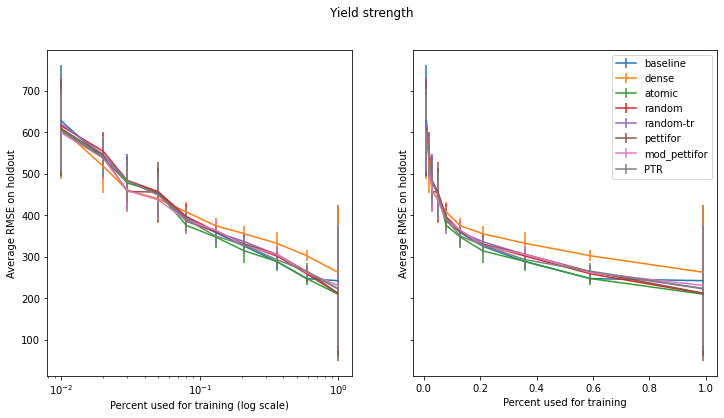

In [14]:
fig,ax  = plt.subplots(1,2,figsize= (12,6), sharey = True)

ax = ax.ravel()
for j,c in enumerate([True,False]):
    for method in method_dict.keys():
        random_subsampling_dict = method_dict[method]
        mean_list = []
        std_list = []
        for i in random_subsampling_dict.keys():
            mean = np.mean(random_subsampling_dict[i]['rmse'])
            std = np.std(random_subsampling_dict[i]['rmse'])
            mean_list.append(mean)
            std_list.append(std)
        ax[j].errorbar(random_subsampling_dict.keys(),mean_list, yerr = std_list ,label = method)
        if c:
                ax[j].set_xlabel('Percent used for training (log scale)')
                ax[j].set_xscale('log')
        else:
                ax[j].set_xlabel('Percent used for training')
        ax[j].set_ylabel('Average RMSE on holdout')
fig.suptitle('Yield strength')
plt.legend()

## Individual elements as holdout set

### making split

In [21]:
selected_els = list(get_elem_count(comps).keys())
filename = 'misc/hea_ys_gen_splits.json'
create_new = False
if os.path.exists(filename) and not create_new:
    with open(filename,'rb') as fid:
        hea_ys_gen_dict = json.load(fid)
        print('Split file loaded')
else:
    hea_ys_gen_dict = {}
    for el in selected_els:
        train_inds, test_inds,all_cv_train, all_cv_test = [],[],[],[]
        for i,c in enumerate(pmg_comps):
            if el in c.get_el_amt_dict().keys():
                test_inds.append(i)
            else:
                train_inds.append(i)
        X_train = np.array(pmg_comps)[train_inds]
        try:
            kf = KFold(n_splits=10, random_state=0,shuffle=True).split(X_train,y[train_inds])
            for tr, ts in kf:
                all_cv_train.append(tr.tolist())
                all_cv_test.append(ts.tolist())
            hea_ys_gen_dict[el] = {'train':train_inds,'test':test_inds, 'cv_train':all_cv_train, 'cv_test':all_cv_test}
        except:
            pass
    with open(filename,'w') as fid:
        json.dump(hea_ys_gen_dict, fid)
        print('Split file written!')

Split file written!


### training RFC models

In [24]:
methods = ['baseline','dense','atomic','random','random-tr','pettifor','mod_pettifor','PTR']
dset = data_generator_vec(pymatgen_comp(comps))

LOEO_dict = {}
for k in hea_ys_gen_dict.keys():
    LOEO_dict[k] = {}
    temp_dict = hea_ys_gen_dict[k]
    holdout_test = temp_dict['test']
    cv_train, cv_test = temp_dict['cv_train'], temp_dict['cv_test']
    temp_dict = {}
    for i, method in enumerate(methods):
        print(method)
        if method == 'baseline':
            features = dset.real_data
        else:
            if method == 'atomic':
                extracted = enc1d_features(pmg_comps,'atomic')
            elif method == 'random':
                extracted = enc1d_features(pmg_comps,'random')
            elif method == 'random-tr':
                extracted = enc1d_features(pmg_comps,'random-tr')
            elif method == 'pettifor':
                extracted = enc1d_features(pmg_comps,'pettifor')
            elif method == 'mod_pettifor':
                extracted = enc1d_features(pmg_comps,'mod_pettifor')
            elif method == 'PTR':
                extracted = get_PTR_features(pmg_comps)
            elif method =='dense':
                extracted = enc1d_features(pmg_comps,'dense')
            ind = component_dict[method]
            pca = PCA(n_components=ind, whiten=True)
            features = pca.fit_transform(extracted)
        features = np.concatenate((features,additional),axis=1)
        rmse_list = []
        r_list = []
        model = Pipeline([('Scaler', StandardScaler()),('RF',RandomForestRegressor(n_jobs=-1, random_state=0))])
        temp_dict = {}
        for i, (train_inds, test_inds) in enumerate(zip(*[cv_train,cv_test])):
                train_features = features[train_inds]
                train_y = y[train_inds]
                model.fit(train_features,train_y)
                #yte_pred= model.predict(features[test_inds])
                yte_pred_holdout = model.predict(features[holdout_test])
                rmse_list.append(rmse(yte_pred_holdout,y[holdout_test]))
                r_list.append(corr(yte_pred_holdout,y[holdout_test]))
        temp_dict[method] = {'rmse': rmse_list,'r':r_list}
        #print(f'Element : {k}, Method : {method} , RMSE : {ufloat(np.mean(rmse_list),np.std(rmse_list))}')
        if len(list(LOEO_dict[k].keys())) == 0:
            LOEO_dict[k] = temp_dict
        else:
            LOEO_dict[k] = LOEO_dict[k]|temp_dict

baseline
dense
atomic
random
random-tr
pettifor
mod_pettifor
PTR
baseline
dense
atomic
random
random-tr
pettifor
mod_pettifor
PTR
baseline
dense
atomic
random
random-tr
pettifor
mod_pettifor
PTR
baseline
dense
atomic
random
random-tr
pettifor
mod_pettifor
PTR
baseline
dense
atomic
random
random-tr
pettifor
mod_pettifor
PTR
baseline
dense
atomic
random
random-tr
pettifor
mod_pettifor
PTR
baseline
dense
atomic
random
random-tr
pettifor
mod_pettifor
PTR
baseline
dense
atomic
random
random-tr
pettifor
mod_pettifor
PTR
baseline
dense
atomic
random
random-tr
pettifor
mod_pettifor
PTR
baseline
dense
atomic
random
random-tr
pettifor
mod_pettifor
PTR


In [25]:
methods = ['dense','atomic','random','random-tr','pettifor','mod_pettifor','PTR']
for method in methods:
    dev_list = []
    for key in LOEO_dict.keys():
        temp_dev = np.array(LOEO_dict[key][method]['rmse']) - np.array(LOEO_dict[key]['baseline']['rmse'])
        dev_list.append(temp_dev)
    dev_list = np.array(dev_list).flatten()
    print(f'Method : {method}, Mean : {np.mean(temp_dev)}, Std : {np.std(temp_dev)}')

Method : dense, Mean : -27.087781748272523, Std : 34.128322134005735
Method : atomic, Mean : -17.081742804671215, Std : 25.064376825964896
Method : random, Mean : -20.557932732420632, Std : 16.764814521368688
Method : random-tr, Mean : -11.565347500279287, Std : 9.111722934922927
Method : pettifor, Mean : -43.00116269540723, Std : 26.573607855108378
Method : mod_pettifor, Mean : 32.479980109563705, Std : 2.7844218093679314
Method : PTR, Mean : -30.98270366696238, Std : 21.25485696645258


In [26]:
test_df = pd.DataFrame.from_dict(LOEO_dict,orient='index')
def alternate_text(x):
    mean = np.round(np.mean(x['rmse']),3)
    std = np.round(np.std(x['rmse']),3)
    return ufloat(mean,std)

test_df = test_df.applymap(alternate_text)
test_df

,baseline,dense,atomic,random,random-tr,pettifor,mod_pettifor,PTR
Al,103+/-15,123+/-13,95+/-9,97+/-12,105+/-9,117+/-13,112+/-14,110+/-18
Mo,249+/-6,265+/-10,266+/-7,247+/-12,312+/-18,259+/-9,256+/-14,263+/-17
Nb,416+/-21,416+/-18,385+/-19,350+/-14,400+/-23,403+/-18,400+/-21,363+/-24
Ti,433+/-23,418+/-17,382+/-18,350+/-12,420+/-24,409+/-14,409+/-12,372+/-18
V,221+/-10,270+/-10,239+/-6,225+/-11,272+/-16,262+/-7,214+/-9,235+/-9
Ta,454+/-10,431+/-18,356+/-9,352+/-7,387+/-11,402+/-14,477+/-21,399+/-20
Zr,473+/-17,390+/-12,339+/-16,311+/-7,359+/-14,404+/-13,411+/-18,360+/-26
Hf,258+/-11,274+/-12,272+/-11,273+/-11,280+/-12,254+/-7,267+/-8,249+/-9
Cr,93+/-14,107+/-19,82+/-16,91+/-18,98+/-17,108+/-19,93+/-19,86+/-11
W,262+/-27,234+/-11,244+/-14,241+/-21,250+/-28,219+/-14,294+/-27,231+/-24
